In [ ]:
!rm -r ./*
!git clone https://github.com/Mamiglia/BNN_Human_motion
!mv BNN_Human_motion/* .
!pip install bayesian-torch lightning

In [2]:
from funcs.dataloader import *
from funcs.loss import mpjpe_error
from funcs.autoformer.Light_Autoformer import LitAutoformer
import torch.optim as optim
import torch.autograd
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import lightning as L
from tqdm import tqdm

from funcs.utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Only some nodes are used
dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                     26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                     46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                     75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

In [4]:
# Load data
data, vald, t = load_dataset()

Loading Train Dataset...
Loading Validation Dataset...
Loading Test Dataset...
>>> Training dataset length: 180077
>>> Validation dataset length: 28110
>>> Test dataset length: 3840


In [5]:
# Configuration File
class Configs:
    def __init__(self, seq_len, pred_len, dec, output_attention=False, moving_avg=3):
        self.samples = 100
        self.num_batches = len(data)
        self.label_len = seq_len//2
        self.seq_len = seq_len
        self.dec = dec
        self.pred_len = pred_len
        self.output_attention = output_attention
        self.moving_avg = moving_avg
        self.enc_in=66
        self.d_model=66
        self.embed='fixed'
        self.freq='h'
        self.dropout=0
        self.e_layers=1
        self.c_out=66
        self.factor=1
        self.n_heads=1
        self.d_ff=66
        self.activation="relu"
        self.lr=1e-02
        self.gamma=0.5
        self.milestones=[10,10,10,10,10,10,10,10]
        self.weight_decay=0

### BAYESIAN MODEL


In [ ]:
device = "cuda"
configs_bayes = Configs(seq_len=10, pred_len=25, dec="bayes")
bayes_model = LitAutoformer.load_from_checkpoint(checkpoint_path="/content/funcs/autoformer/weights/bayes_weights.ckpt",
                                                configs=configs_bayes).to(device)

In [ ]:
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(monitor="validation mpjpe", min_delta=0.5, patience=5, verbose=True)
trainer = L.Trainer(accelerator='gpu',
                    default_root_dir="logs/transformer/",
                    callbacks = [early_stop_callback],
                    max_epochs=50)

trainer.fit(model=bayes_model, train_dataloaders=data, val_dataloaders=vald)

### TRADITIONAL "FREQUENTIST" MODEL

In [ ]:
configs_freq = Configs(seq_len=10, pred_len=25, dec="freq")
freq_model = LitAutoformer.load_from_checkpoint(checkpoint_path="/content/funcs/autoformer/weights/freq_weights.ckpt",
                                                configs=configs_freq)

In [ ]:
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(monitor="validation mpjpe", min_delta=0.5, patience=5, verbose=True)
trainer = L.Trainer(
      accelerator='gpu',
      default_root_dir="logs/transformer/",
      callbacks = [early_stop_callback],
      max_epochs=50)

trainer.fit(model=freq_model, train_dataloaders=data, val_dataloaders=vald)

### CONFIDENCE INTERVALS AND SOME ESTIMATIONS


In [9]:
ci_batch = []
mu_batch = []
isin_batch = []
dev_batch = []
output_n = 25
input_n = 10
with torch.no_grad():
  for batch in tqdm(vald):
      bayes_model.eval()
      batch = batch[:,:,dim_used].to(device)
      # MEAN VALUES and CONFIDENCE INTERVAL
      m,c = bayes_model.build_ci(batch,reps=300,alpha=0.1)
      m = m.view(-1,output_n,len(dim_used)//3,3)
      sequences_gt = batch[:, input_n:input_n+output_n, :].view(-1,output_n,len(dim_used)//3,3).to(device)
      # DISTANCE FROM GROUND TRUTH
      dev = torch.linalg.vector_norm(m - sequences_gt, dim=-1).numpy(force=True)
      # HOW MANY TIMES THE GROUND TRUTH IS IN THE INTERVAL?
      isin = dev < c

      isin_batch.append(isin)
      dev_batch.append(dev)
      mu_batch.append(m)
      ci_batch.append(c)

mu = torch.concatenate(mu_batch, axis=0)
ci = np.concatenate(ci_batch, axis=0)
dev = np.concatenate(dev_batch, axis=0)
isin = np.concatenate(isin_batch, axis=0)

[Text(0.5, 1.0, 'Median upper bound confidence interval (Autoformer)'),
 Text(50.58159722222221, 0.5, 'Joint'),
 Text(0.5, 23.52222222222222, 'Time')]

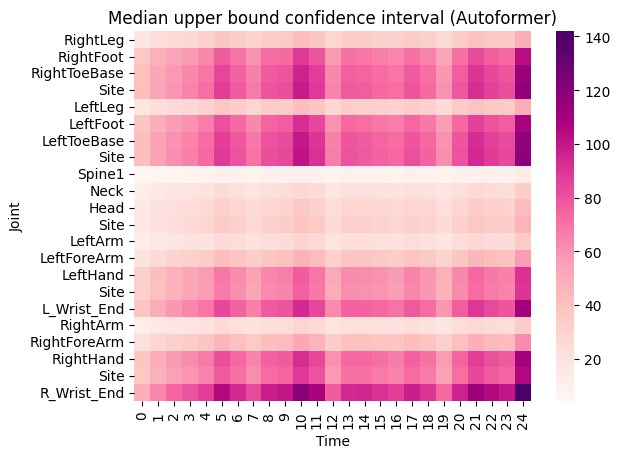

In [10]:
joint_name = ["Hips", "RightUpLeg", "RightLeg", "RightFoot", "RightToeBase", "Site", "LeftUpLeg", "LeftLeg","LeftFoot",
              "LeftToeBase", "Site", "Spine", "Spine1", "Neck", "Head", "Site", "LeftShoulder", "LeftArm","LeftForeArm",
              "LeftHand", "LeftHandThumb", "Site", "L_Wrist_End", "Site", "RightShoulder", "RightArm","RightForeArm",
              "RightHand", "RightHandThumb", "Site", "R_Wrist_End", "Site"]
dim_used = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
            26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
            46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
            75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92]
joint_names = [joint_name[i//3] for i in dim_used if i%3 == 0]

mu = ci.mean(axis=0).T
sigma = ci.std(axis=0).T
me = np.quantile(ci,0.5, axis=0).T
ma = ci.max(axis=0).T
isin_max = isin.sum(axis=0).T

sns.heatmap(me, yticklabels = joint_names, cmap='RdPu').set(
    title = 'Median upper bound confidence interval (Autoformer)',
    ylabel = 'Joint',
    xlabel = 'Time'
)

[Text(0.5, 1.0, 'Accuracy of Confidence Interval (Autoformer)'),
 Text(50.58159722222221, 0.5, 'Joint'),
 Text(0.5, 23.52222222222222, 'Time')]

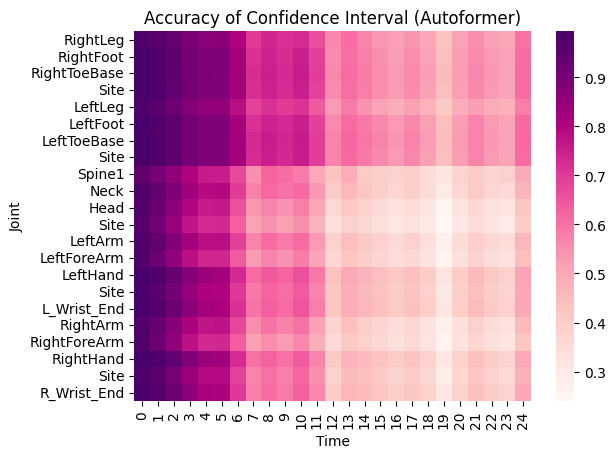

In [11]:
sns.heatmap(isin_max/28110, yticklabels = joint_names, cmap='RdPu').set(
    title = 'Accuracy of Confidence Interval (Autoformer)',
    ylabel = 'Joint',
    xlabel = 'Time'
)

[Text(0.5, 1.0, 'Loss VS Confidence (Autoformer)'),
 Text(0.5, 0, 'Confidence Interval range'),
 Text(0, 0.5, 'Loss (MPJPE)')]

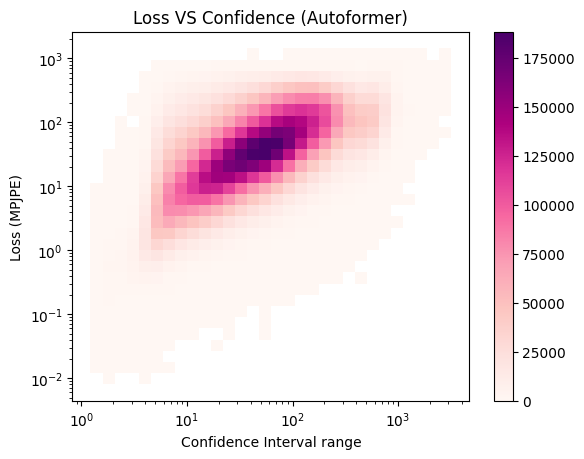

In [12]:
d = {"dev":dev.flatten(),"conf":ci.flatten()}
df = pd.DataFrame.from_dict(data=d)

sns.histplot(data=df, x='conf', y='dev', log_scale=True, bins=30,
  cbar=True,
  cmap = 'RdPu',
).set(
    title = 'Loss VS Confidence (Autoformer)',
    xlabel = 'Confidence Interval range',
    ylabel = 'Loss (MPJPE)',
)

In [ ]:
def test():
    bayes_model.eval()
    accum_loss = 0
    n_batches = 0
    input_n=10
    output_n=25
    actions = ["walking", "eating", "smoking", "discussion", "directions",
               "greeting", "phoning", "posing", "purchases", "sitting",
               "sittingdown", "takingphoto", "waiting", "walkingdog",
               "walkingtogether"]
    dim_used = np.array([ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                          26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                          46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                          75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92 ])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])

    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal*3, joint_equal*3+1, joint_equal*3+2))
    totalll = 0
    counter = 0
    for action in actions:
      running_loss = 0
      n = 0
      dataset_test = datasets.Datasets('./data/h3.6m/h3.6m/dataset', input_n, 25, 1, split=2, actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                      batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]
          sequences_predict1,_ = bayes_model(sequences_train1,100)
          sequences_predict1 = sequences_predict1.mean(0)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])

          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)

          sequences_predict2,_=bayes_model(sequences_train2,100)
          sequences_predict2 = sequences_predict2.mean(0)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,14:15,:])

          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1[:,:15,:],sequences_predict2[:,:10,:]),1)

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss = mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss += loss*batch_dim
          accum_loss += loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: ' + str(np.round((accum_loss/n_batches).item(),1)))

In [ ]:
test()

walking :  56.1
eating :  50.1
smoking :  49.1
discussion :  82.5
directions :  70.8
greeting :  102.2
phoning :  66.3
posing :  105.1
purchases :  93.7
sitting :  71.6
sittingdown :  98.1
takingphoto :  70.5
waiting :  73.2
walkingdog :  108.6
walkingtogether :  53.3
Average: 76.7
